# **scAgent Framework - Notebook**
Nicholas Hadas

### Setup
---

In [15]:
# Import packages
import os
import re
import scanpy as sc
import io
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.chat_models import ChatOllama
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain import hub

In [ ]:
# Set wd
os.chdir("/home/nico/Documents/Python/Agentic_AI")
os.getcwd()

In [4]:
# Load sctnormalized scrna-seq data
adata = sc.read_h5ad("Objects/PCD_obj_anndata.h5ad")

In [44]:
input_q = "Show me a UMAP plot of KRT5 expression, making sure to label the clusters by cell type"

### Agent
---

/home/nico/anaconda3/envs/scAgent/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Asking agent to generate a plan


> Entering new AgentExecutor chain...
**Step‑by‑step plan**

1. **Verify prerequisites**  
   * Make sure the UMAP coordinates are stored in `adata.obsm['X_umap']`.  
   * Confirm that the gene *KRT5* is present in `adata.var_names`.

2. **Plot the UMAP**  
   * Use `scanpy.pl.umap` to create a scatter plot where each cell is coloured by its *KRT5* expression level.  
   * Disable the automatic display (`show=False`) so we can add custom annotations later.

3. **Compute cluster centroids**  
   * Extract the UMAP coordinates and attach the corresponding cell‑type labels.  
   * Group by `Cell_Type` and compute the mean UMAP1/UMAP2 coordinates – these are the centroids.

4. **Annotate the plot**  
   * For each centroid, add a text label with the cell‑type name.  
   * Use a light background box so the labels are readable over the coloured points.

5. **Display the figure**  
   * Call `plt.show()` to render the final plot.

---

```python
import scanpy

<string>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


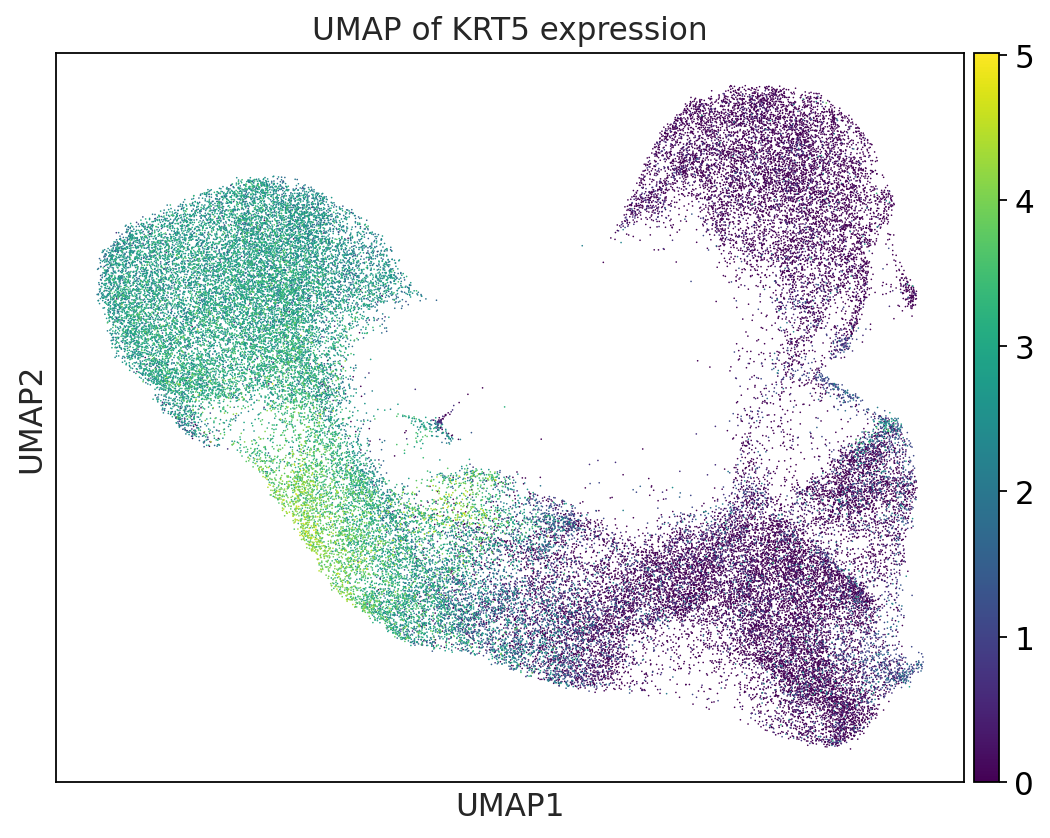

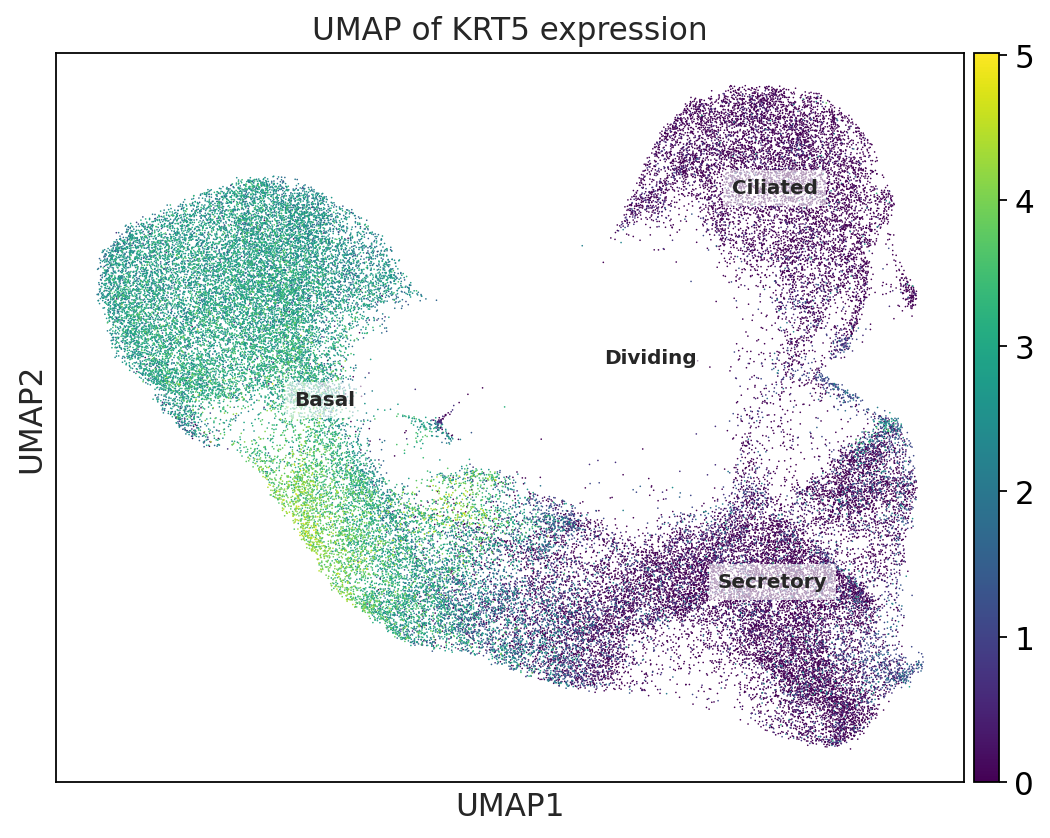

Execution successful
Final Summary

--- FINAL AGENT RESPONSE ---
The script ran successfully, but it did not produce any printed output to summarize. This can happen when the task was to generate a plot, which was saved to a file.


In [ ]:
# --- Initialize Agent ---
llm = ChatOllama(model="gpt-oss:20b", temperature=0) # load llm
persistent_env = {"adata": adata, "sc": sc, "np": np, "pd": pd, "plt": plt} # shared memory and execution env
tools = [] # kept empty, as we just need a plan
prompt = hub.pull("hwchase17/openai-functions-agent")
agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent,tools=tools,verbose=True)

# --- Generate Plan 
user_question = input_q
input_prompt = f"""
You are an expert bioinformatician. Your task is to answer the following question about the pre-loaded AnnData object 'adata'.
Provide a step-by-step explanation and a single, complete Python code block that accomplishes the entire task.

The 'adata' object has metadata columns: {adata.obs.columns.tolist()}. Where:
- `adata.obs['Cell_Type']` contains cell type annotations (e.g., 'Ciliated', 'Secretory').
- `adata.obs['Condition']` contains the group ('PCD' or 'Control').
- `adata.obs['Variant']` contains specific genetic variants.

Question: {user_question}
"""
print("Asking agent to generate a plan")
response = agent_executor.invoke({"input": input_prompt}) # generate 
generated_plan = response["output"] 
print(f"Plan Generated: \n{generated_plan}")

# --- Execute and Self-correct 
code_blocks = re.findall(r"```python\n(.*?)\n```", generated_plan, re.DOTALL) # get only python code
execution_output = ""
if not code_blocks:
    print("No code blocks found")
else:
    code_to_execute = code_blocks[-1] # acquire only final copy-pastable code
    max_retries = 2
    retries = 0

    while retries < max_retries:
        print(f"Attempt {retries + 1} of {max_retries} to execute script")
        print(code_to_execute)
        try:
            string_io = io.StringIO()
            with contextlib.redirect_stdout(string_io):
                exec(code_to_execute, globals(), persistent_env)
            execution_output = string_io.getvalue()
            print("Execution successful")
            break 
        except Exception as e:
            error_message = str(e)
            print(f"ERROR during execution: {error_message}")
            retries += 1
            if retries >= max_retries:
                print("Max retries reached, halting execution")
                break
            
            # Self-correcting 
            print("Asking LLM to correct the code") 
            correction_prompt = f"""
            The following Python code failed to execute with an error. Your task is to fix it.

            Original Code:
            ```python
            {code_to_execute}
            ```

            Error Message:
            {error_message}

            Analyze the error and provide a corrected version of the full Python code block.
            Respond with ONLY the corrected, complete Python code inside a single ```python block.
            """
            correction_response = llm.invoke(correction_prompt).content # llm corrects code not the agent
            corrected_code_blocks = re.findall(r"```python\n(.*?)\n```", correction_response, re.DOTALL) # extract corrected code
            if corrected_code_blocks:
                code_to_execute = corrected_code_blocks[0] 
                print("Received corrected code from LLM, retrying")
            else:
                print("LLM did not provide a valid corrected code block, halting")
                break

# --- Final Summary 
print("Final Summary")

if not execution_output.strip():
    final_summary = "The script ran successfully, but it did not produce any printed output to summarize. This can happen when the task was to generate a plot, which was saved to a file."
else:
    final_answer_prompt = f"""
    You are a helpful AI assistant. Your job is to provide a final, human-readable answer to the user's question based on the output of a Python script.

    Original Question: {user_question}

    The script was executed successfully. Here is the output it printed:
    --- SCRIPT OUTPUT ---
    {execution_output}
    --- END SCRIPT OUTPUT ---

    Based on this output, provide a concise, final answer. Simply rephrase the conclusion from the script output in a clear way and give us the key results.
    """
    final_summary = llm.invoke(final_answer_prompt).content

print("\n--- FINAL AGENT RESPONSE ---")
print(final_summary)